In [19]:
%matplotlib inline

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co

In [20]:
adata = sc.read_h5ad('intermediate_data/2_delile.h5ad')

In [21]:
# Load base GRN, data taken from https://atlas.gs.washington.edu/mouse-atac/
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

# Check data
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Instantiate oracle object 
oracle = co.Oracle()

In [23]:
# Set raw counts as the input
adata.X = adata.layers['counts'].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="Type_step2",
                                   embedding_name="X_pca")

In [24]:
# Import TF data into oracle
oracle.import_TF_data(TF_info_matrix=base_GRN)

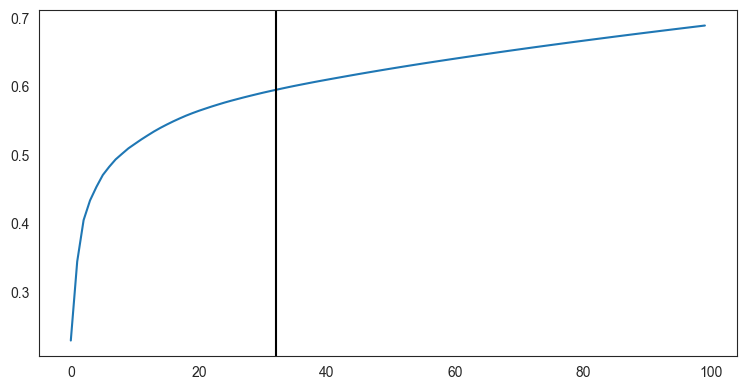

32


In [25]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [26]:
# Calculate k from num_cells
num_cells = adata.shape[0]
k = int(0.025*num_cells)

# KNN 
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [27]:
# Save oracle object.
oracle.to_hdf5("intermediate_data/3_delile.celloracle.oracle")

In [28]:
# Calcualte GRNs for each cluster identity
links = oracle.get_links(cluster_name_for_GRN_unit="Type_step2", alpha=10,
                         verbose_level=10)

  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for MN...


  0%|          | 0/1702 [00:00<?, ?it/s]

Inferring GRN for pMN...


  0%|          | 0/1702 [00:00<?, ?it/s]

In [29]:
# Filter links with high p-values
links.filter_links(p=0.001, weight="coef_abs", threshold_number=10000)

MN


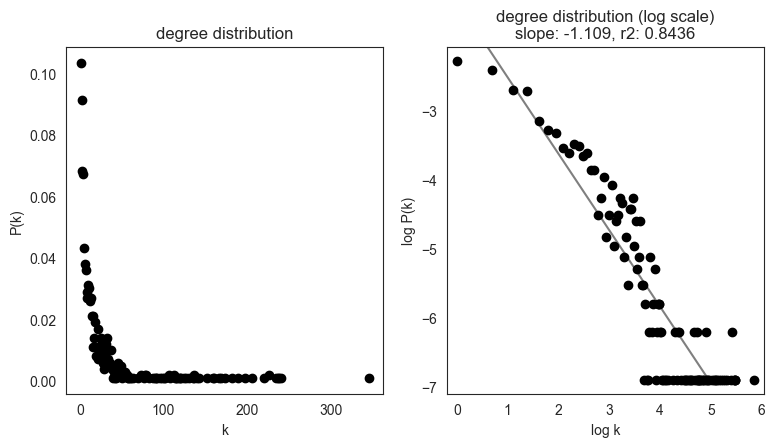

pMN


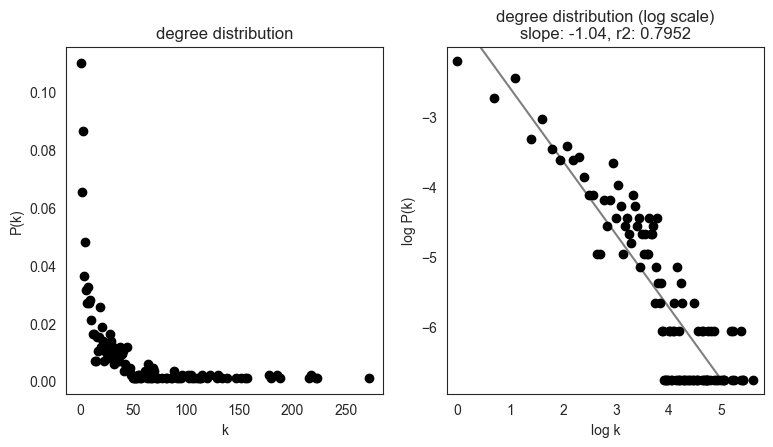

In [30]:
# Plot degree distribution
plt.rcParams["figure.figsize"] = [9, 4.5]
links.plot_degree_distributions(plot_model=True)

In [31]:
# Calculate network scores
links.get_network_score()
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Klf7,353,0.355131,17,0.017103,336,0.338028,11153.0,1.000000,MN
Snhg11,11,0.011066,11,0.011066,0,0.000000,0.0,0.297697,MN
Nhlh2,226,0.227364,0,0.000000,226,0.227364,0.0,0.519613,MN
Sox4,45,0.045272,19,0.019115,26,0.026157,230.0,0.291341,MN
Meg3,38,0.038229,38,0.038229,0,0.000000,0.0,0.262682,MN


In [32]:
# Save GRNs
links.to_hdf5(file_path="intermediate_data/3_delile.celloracle.links")

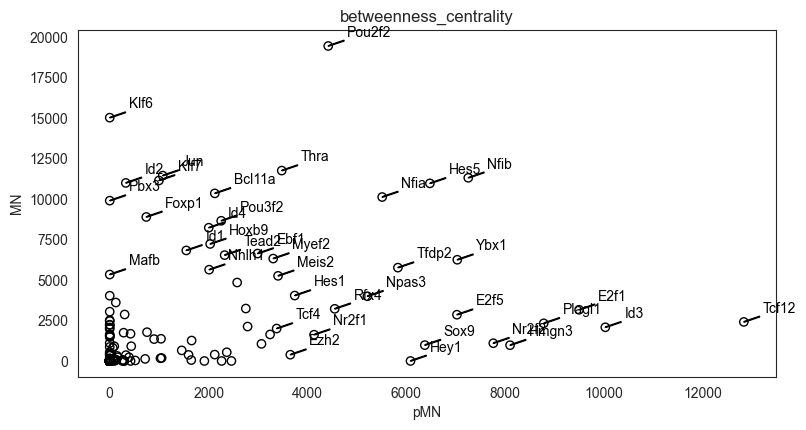

In [33]:
# Compare GRN scores between dp4, dl4
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="pMN", cluster2="MN",
                               percentile=98)